In [18]:
import pickle
import torch
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import numpy as np
from adabmDCA.utils import get_device, get_dtype, get_mask_save

import sys
sys.path.append('..')
import indep_sites

In [3]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = range(len(round_ids))
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [5]:
def load_frequences(experiment_id, pseudocount):
    pc_str = format(pseudocount, '.2f')
        
    filename = experiment_id + "freq_pseudocount" + pc_str + ".pkl"
    filepath = "saved/freq_pseudocount/" + filename
    
    with open(filepath, 'rb') as f:
        fi, fij, total_reads = pickle.load(f)

    return fi, total_reads

In [10]:
fi_all, total_reads_all = zip(*[load_frequences(id, 0) for id in experiment_ids])

In [79]:
import importlib
importlib.reload(indep_sites);

In [93]:
n = 0
lr = 0.01
max_epochs=10**5

params_all = []
history_all = []

for n in range(len(experiment_ids)):
    params, history = indep_sites.train(
        fi=fi_all[n],
        total_reads=total_reads_all[n], 
        params=indep_sites.init_parameters(fi_all[n]),
        lr=lr,
        max_epochs=max_epochs,
        target_error=1e-6,
        progress_bar=False)
    
    params_all.append(params)
    history_all.append(history)

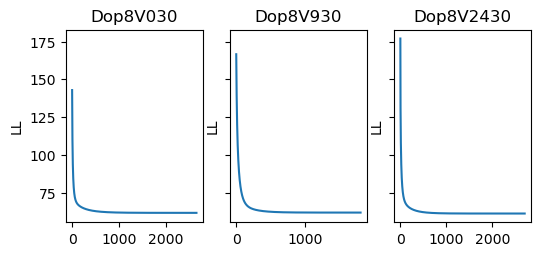

In [94]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(6,2.5))
for n in range(len(experiment_ids)):
    ax = axes[n]
    ax.plot(history_all[n]["log-likelihood"])
    ax.set_title(f"{experiment_ids[n]}")
    ax.set_ylabel("LL")